### Import Statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import warnings
from scipy import stats
from scipy.stats import spearmanr
import scikit_posthocs as sp
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn import preprocessing

### Loading in data

In [2]:
#Loading in Qualtrics Survey data
surveydata = pd.read_excel(r'/Users/guusjejuijn/Desktop/Scriptie/Prolific /RESULTS/finalresults.xlsx')

#Drop columns/rows that are not needed for our analysis
surveydata = surveydata.iloc[2:] 
surveydata = surveydata.reset_index() 
surveydata = surveydata.drop(columns=["index", "StartDate", "EndDate", "Status", "Progress", "Finished", "RecordedDate", 
                                "ResponseId", "DistributionChannel", "UserLanguage"], axis=1) 
surveydata = surveydata.drop(columns=surveydata.columns[0:2])

#Split results dataframe into scores, prolific id and openquestions 
scores = surveydata.iloc[:, 1: 31] 
prolificid = surveydata.iloc[:,0]
openquestions = surveydata.iloc[:,31:35]

#Convert object types to float to make sure we can calculate average scores 
scores = scores.astype(float)

#Make final dataframe of survey data
surveydata = pd.concat([scores, prolificid, openquestions], axis=1) 

#Give clear names to columns
surveydata.columns = ["ORIG_A_D", "DPM_A_D", "DPP_A_D", "EQOM_A_D", "EQOP_A_D", 
                   "ORIG_B_D", "DPM_B_D", "DPP_B_D", "EQOM_B_D", "EQOP_B_D", 
                   "ORIG_A_PS", "DPM_A_PS", "DPP_A_PS", "EQOM_A_PS", "EQOP_A_PS", 
                   "ORIG_B_PS", "DPM_B_PS", "DPP_B_PS", "EQOM_B_PS", "EQOP_B_PS",
                   "ORIG_A_PNS", "DPM_A_PNS", "DPP_A_PNS", "EQOM_A_PNS", "EQOP_A_PNS",
                   "ORIG_B_PNS", "DPM_B_PNS", "DPP_B_PNS", "EQOM_B_PNS", "EQOP_B_PNS","Prolific_ID", 
                   "Factors", "AI_exp", "Gender", "Education"] 

surveydata.head(5)

,ORIG_A_D,DPM_A_D,DPP_A_D,EQOM_A_D,EQOP_A_D,ORIG_B_D,DPM_B_D,DPP_B_D,EQOM_B_D,EQOP_B_D,...,ORIG_B_PNS,DPM_B_PNS,DPP_B_PNS,EQOM_B_PNS,EQOP_B_PNS,Prolific_ID,Factors,AI_exp,Gender,Education
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,62fb8276f170965e7e3899e7,Gender has no roll in these algorithms.,No,Male,Doctorate degree (PhD/other)
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,5.0,6.0,3.0,5.0,632894c7f1354613c682cd01,percentage of genders accepted,Computer science,Male,Technical/community college
2,2.0,3.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,620297b8ef1cb18a1337c16d,type of data is collected and compared,GCSE Computer Science - A grade. Not further t...,Female,Technical/community college
3,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,59479251f236120001ecf9a2,the more overall ballanced,none,Male,High school diploma
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,1.0,5.0,4.0,62dc60fd3b07c18f1dcfdda6,"% qualified, but not hired",No,Male,High school diploma


In [3]:
#Loading in Prolific data 
prolificdata = pd.read_excel(r'/Users/guusjejuijn/Desktop/Scriptie/Prolific /RESULTS/prolificresults.xlsx')

#Drop columns that are either not imported for our analysis, or contain only 1 value (e.g. nationality)   
prolificdata = prolificdata.drop(columns = ['Submission id', 'Status', 'Started at', 'Completed at', 
                                                  'Reviewed at', 'Archived at', 'Completion code', 'Total approvals',
                                                 'Highest education level completed', 'Sex', 'Country of birth', 
                                                 'Country of residence', 'Nationality', 'Language', 'Student status',
                                                 'Employment status'])                                  
#Rename columns
prolificdata.columns = ["Prolific_ID", "Time", "Age", "Ethnicity"] 

prolificdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Prolific_ID  227 non-null    object
 1   Time         227 non-null    int64 
 2   Age          227 non-null    int64 
 3   Ethnicity    227 non-null    object
dtypes: int64(2), object(2)
memory usage: 7.2+ KB


In [4]:
#Merge Qualtrics and Prolific data, based on prolific id values 
results = pd.merge(surveydata, prolificdata, on="Prolific_ID")

### Results splitted on groups 

In [5]:
#Results group 1: distributive fairness 

#Select results of group 1, question set A 
results_A_dist = results[~results['ORIG_A_D'].isnull()] 

results_A_dist = results_A_dist.drop(results_A_dist.columns[5:30], axis=1) #drop the irrelevant rows 

#Select results of group 1, question set B
results_B_dist = results[~results['ORIG_B_D'].isnull()] 
results_B_dist = results_B_dist.drop(results_B_dist.columns[0:5], axis=1)
results_B_dist = results_B_dist.drop(results_B_dist.columns[5:25], axis=1)

#Rename columns so that we can match the results from group 1A and group 1B
results_A_dist.columns = ['Original', 'DP-M', 'DP-P', 'EQO-M', 'EQO-P', 
                          'Prolific_ID', 'Factors', 'AI-exp', 'Gender', 
                          'Education', 'Time', 'Age', 'Ethnicity']
results_B_dist.columns =  results_A_dist.columns 

#Concatenate results from group 1A and group 1B to get all results of group 1 
results_dist = pd.concat([results_A_dist, results_B_dist],ignore_index=True) 

#Calculate each participant's average score for the DP (demographic parity) models and EQO (equality of opportunity) models
results_dist["DP_av"] = results_dist[["DP-M", "DP-P"]].mean(axis=1) 
results_dist["EQO_av"] = results_dist[["EQO-M", "EQO-P"]].mean(axis=1) 

results_dist.describe()


,Original,DP-M,DP-P,EQO-M,EQO-P,Time,Age,DP_av,EQO_av
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,2.466667,3.213333,3.040000,3.266667,3.346667,263.066667,38.120000,3.126667,3.306667
std,1.349007,1.348606,1.510683,1.368895,1.735896,124.816983,12.873564,1.241439,1.404369
min,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000,19.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,174.000000,28.000000,2.250000,2.000000
50%,2.000000,3.000000,3.000000,3.000000,3.000000,232.000000,36.000000,3.000000,3.000000
75%,3.000000,4.000000,3.500000,4.500000,5.000000,313.500000,44.000000,4.000000,4.000000
max,7.000000,6.000000,7.000000,6.000000,7.000000,645.000000,72.000000,6.500000,6.500000


In [6]:
#Results group 2: distributive + procedural, with sensitive attribute. 

#Select results of group 2, question set A 
results_A_procsens = results[~results['ORIG_A_PS'].isnull()]
results_A_procsens = results_A_procsens.drop(results_A_procsens.columns[0:10], axis=1)
results_A_procsens = results_A_procsens.drop(results_A_procsens.columns[5:20], axis=1)

#Select results of group 2, question set B 
results_B_procsens = results[~results['ORIG_B_PS'].isnull()]
results_B_procsens = results_B_procsens.drop(results_B_procsens.columns[0:15], axis=1)
results_B_procsens = results_B_procsens.drop(results_B_procsens.columns[5:15], axis=1)

#Rename columns so that we can match the results from group 2A and group 2B
results_A_procsens.columns = ['Original', 'DP-M', 'DP-P', 'EQO-M', 'EQO-P', 
                          'Prolific_ID', 'Factors', 'AI-exp', 'Gender', 
                          'Education', 'Time', 'Age', 'Ethnicity']
results_B_procsens.columns = results_A_procsens.columns

#Concatenate results from group 2A and group 2B to get all results of group 2
results_procsens = pd.concat([results_A_procsens, results_B_procsens],ignore_index=True) 

#Calculate each participant's average score for the DP (demographic parity) models and EQO (equality of opportunity) models
results_procsens["DP_av"] = results_procsens[["DP-M", "DP-P"]].mean(axis=1) 
results_procsens["EQO_av"] = results_procsens[["EQO-M", "EQO-P"]].mean(axis=1) 

results_procsens.describe()

,Original,DP-M,DP-P,EQO-M,EQO-P,Time,Age,DP_av,EQO_av
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,3.000000,3.813333,3.440000,4.000000,4.106667,290.480000,39.213333,3.626667,4.053333
std,1.414214,1.512947,1.570333,1.345664,1.493891,189.845055,15.596512,1.390346,1.245460
min,1.000000,1.000000,1.000000,1.000000,1.000000,108.000000,19.000000,1.000000,1.000000
25%,2.000000,3.000000,2.000000,3.000000,3.000000,182.000000,26.000000,2.500000,3.000000
50%,3.000000,3.000000,3.000000,4.000000,4.000000,259.000000,37.000000,3.500000,4.000000
75%,4.000000,5.000000,5.000000,5.000000,5.000000,331.500000,53.500000,4.500000,5.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,1537.000000,72.000000,6.500000,6.500000


In [7]:
#Results group 3: distributive + procedural, without sensitive attribute. 

#Select results of group 3, question set A 
results_A_procnosens = results[~results['ORIG_A_PNS'].isnull()]
results_A_procnosens = results_A_procnosens.drop(results_A_procnosens.columns[0:20], axis=1)
results_A_procnosens = results_A_procnosens.drop(results_A_procnosens.columns[5:10], axis=1)


#Select results of group 3, question set B 
results_B_procnosens = results[~results['ORIG_B_PNS'].isnull()]
results_B_procnosens = results_B_procnosens.drop(results_B_procnosens.columns[0:25], axis=1)

#Rename columns so that we can match the results from group 3A and group 3B
results_A_procnosens.columns = ['Original', 'DP-M', 'DP-P', 'EQO-M', 'EQO-P', 
                          'Prolific_ID', 'Factors', 'AI-exp', 'Gender', 
                          'Education', 'Time', 'Age', 'Ethnicity']
results_B_procnosens.columns = results_A_procnosens.columns

#Concatenate results from group 3A and group 3B to get all results of group 3
results_procnosens = pd.concat([results_A_procnosens, results_B_procnosens],ignore_index=True) 

#Calculate each participant's average score for the DP (demographic parity) models and EQO (equality of opportunity) models
results_procnosens["DP_av"] = results_procnosens[["DP-M", "DP-P"]].mean(axis=1) 
results_procnosens["EQO_av"] = results_procnosens[["EQO-M", "EQO-P"]].mean(axis=1) 

results_procnosens.describe()

,Original,DP-M,DP-P,EQO-M,EQO-P,Time,Age,DP_av,EQO_av
count,75.00000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,3.16000,3.786667,3.680000,4.200000,4.253333,301.186667,39.946667,3.733333,4.226667
std,1.51604,1.518297,1.595263,1.479591,1.577659,208.896825,13.120948,1.300554,1.400515
min,1.00000,1.000000,1.000000,1.000000,1.000000,89.000000,18.000000,1.000000,1.000000
25%,2.00000,3.000000,3.000000,3.000000,3.000000,185.000000,30.000000,3.000000,3.000000
50%,3.00000,3.000000,3.000000,4.000000,5.000000,252.000000,37.000000,4.000000,4.500000
75%,4.00000,5.000000,5.000000,5.000000,5.500000,348.500000,50.000000,4.500000,5.500000
max,6.00000,7.000000,7.000000,7.000000,7.000000,1378.000000,67.000000,6.000000,7.000000


### Investigate standard deviations of scores given per participant

In [8]:
#calculate standard deviation of scores given by each participant 

results_dist_sd = results_dist.iloc[:, :5] #select only the columns containing perceived fairness scores, for simplicity
results_dist_sd['SD'] = results_dist_sd.std(axis=1) #add a column reporting the standard deviation of each participants' scores
same_scores_dist = results_dist_sd[results_dist_sd['SD'] == 0.000000] #calculate how many participants only gave 1 specific score to each of the algorithms
print(len(same_scores_dist))

results_procsens_sd = results_procsens.iloc[:, :5] #select only the columns containing perceived fairness scores, for simplicity
results_procsens_sd['SD'] = results_procsens_sd.std(axis=1) #add a column reporting the standard deviation of each participants' scores
same_scores_procsens = results_procsens_sd[results_procsens_sd['SD'] == 0.000000] #calculate how many participants only gave 1 specific score to each of the algorithms
print(len(same_scores_procsens))

results_procnosens_sd = results_procnosens.iloc[:, :5] #select only the columns containing perceived fairness scores, for simplicity
results_procnosens_sd['SD'] = results_procnosens_sd.std(axis=1) #add a column reporting the standard deviation of each participants' scores
same_scores_procnosens = results_procnosens_sd[results_procnosens_sd['SD'] == 0.000000] #calculate how many participants only gave 1 specific score to each of the algorithms
print(len(same_scores_procnosens))

8
4
5


### Find out whether there are differences in scores for algorithms perfectly adhering to a criterion, and algorithms mitigated for a criterion

In [9]:
#Write a function to compare two columns in a dataframe -> to find out the differences in scores for algorithms perfectly 
#adhering to DP/EQO or algorithms mitigated for DP/EQO 

def compare_columns(df, col1, col2):
    """
    Compare two columns and create a new column based on the comparison.
    If the value in col1 is smaller than the value in col2, the new column is filled with 'smaller'.
    If the value in col1 is equal to the value in col2, the new column is filled with 'same'.
    If the value in col1 is larger than the value in col2, the new column is filled with 'larger'.
    """
    # compare the two columns and create a new column based on the comparison
    df['comparison'] = df.apply(lambda x: 'smaller' if x[col1] < x[col2] else ('same' if x[col1] == x[col2] else 'larger'), axis=1)
    
    return df


In [34]:
compare_columns(results_dist, 'DP-P', 'DP-M')
results_dist['comparison'].value_counts()

same       31
smaller    28
larger     16
Name: comparison, dtype: int64

In [35]:
compare_columns(results_procsens, 'DP-P', 'DP-M')
results_procsens['comparison'].value_counts()

smaller    31
same       27
larger     17
Name: comparison, dtype: int64

In [36]:
compare_columns(results_procnosens, 'DP-P', 'DP-M')
results_procnosens['comparison'].value_counts()

smaller    28
larger     24
same       23
Name: comparison, dtype: int64

In [37]:
compare_columns(results_dist, 'EQO-P', 'EQO-M')
results_dist['comparison'].value_counts()

same       39
larger     19
smaller    17
Name: comparison, dtype: int64

In [38]:
compare_columns(results_procsens, 'EQO-P', 'EQO-M')
results_procsens['comparison'].value_counts()

same       35
larger     23
smaller    17
Name: comparison, dtype: int64

In [39]:
compare_columns(results_procnosens, 'EQO-P', 'EQO-M')
results_procnosens['comparison'].value_counts()

same       33
smaller    22
larger     20
Name: comparison, dtype: int64

In [10]:
#Find out whether there are significant differences between mitigated algorithms and algorithms perfectly adhering to DP/EQO

print("group 1 DP:", stats.wilcoxon(results_dist['DP-M'], results_dist['DP-P']))
print("group 1 EQO:", stats.wilcoxon(results_dist['EQO-M'], results_dist['EQO-P']))
print()
print("group 2 DP:", stats.wilcoxon(results_procsens['DP-M'], results_procsens['DP-P']))
print("group 2 EQO:", stats.wilcoxon(results_procsens['EQO-M'], results_procsens['EQO-P']))
print()
print("group 3 DP:", stats.wilcoxon(results_procnosens['DP-M'], results_procnosens['DP-P']))
print("group 3 EQO:", stats.wilcoxon(results_procnosens['EQO-M'], results_procnosens['EQO-P']))

group 1 DP: WilcoxonResult(statistic=383.0, pvalue=0.1778650386095184)
group 1 EQO: WilcoxonResult(statistic=305.5, pvalue=0.6594875192713288)

group 2 DP: WilcoxonResult(statistic=367.5, pvalue=0.0190187034036056)
group 2 EQO: WilcoxonResult(statistic=375.0, pvalue=0.6293486341392265)

group 3 DP: WilcoxonResult(statistic=630.5, pvalue=0.5871714518777057)
group 3 EQO: WilcoxonResult(statistic=426.5, pvalue=0.7461413849370553)


### Demographic Information

In [11]:
#Make a subset of the results dataframe containing only the demographic information 
demographic_data = results.drop(results.columns[0:32], axis=1)
del(demographic_data['Time'])
demographic_data

,AI_exp,Gender,Education,Age,Ethnicity
0,No,Male,Doctorate degree (PhD/other),28,White
1,Computer science,Male,Technical/community college,21,White
2,GCSE Computer Science - A grade. Not further t...,Female,Technical/community college,24,Asian
3,none,Male,High school diploma,53,White
4,No,Male,High school diploma,31,White
...,...,...,...,...,...
220,No,Male,High school diploma,50,White
221,a small amount,Male,Technical/community college,44,White
222,Yes a little but not at degree level,Male,High school diploma,49,White
223,A little.,Male,NaN,28,Asian


In [12]:
# Gender distribution
demographic_data['Gender'].unique()
demographic_data['Gender'].value_counts()

Male      112
Female    111
Other       2
Name: Gender, dtype: int64

In [13]:
# Age distribution: divide ages in bins 
demographic_data['agebins'] = pd.cut(x=demographic_data['Age'], bins = [0,30,45,60,76])
demographic_data['agebins'].value_counts()

(30, 45]    80
(0, 30]     75
(45, 60]    50
(60, 76]    20
Name: agebins, dtype: int64

In [14]:
demographic_data['Education'].value_counts()

High school diploma                     120
Technical/community college              88
Undergraduate degree (BA/BSc/other)      12
Doctorate degree (PhD/other)              1
Graduate degree (MA/MSc/Mphil/other)      1
Name: Education, dtype: int64

count    225.000000
mean      39.093333
std       13.876213
min       18.000000
25%       28.000000
50%       37.000000
75%       50.000000
max       72.000000
Name: Age, dtype: float64


<AxesSubplot: ylabel='Density'>

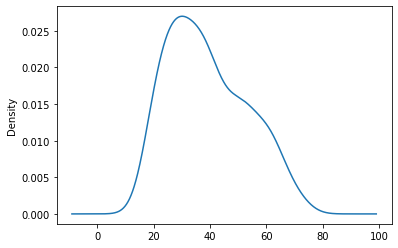

In [15]:
# Age distribution
print(demographic_data['Age'].describe())

demographic_data['Age'].plot(kind='density')

In [16]:
#Ethnicity distribution 
demographic_data['Ethnicity'].unique()
demographic_data['Ethnicity'].value_counts()

White           206
Asian            10
Mixed             6
Black             2
DATA_EXPIRED      1
Name: Ethnicity, dtype: int64

## Descriptive Stats Research Questions

### RQ1: How do human fairness perceptions of a recruitment prediction algorithm differ depending on whether it adheres to demographic parity or equality of opportunity? 

Mean scores per group:
Original algorithm: [2.466666666666667, 3.0, 3.16]
Demographic parity: [3.1266666666666665, 3.6266666666666665, 3.7333333333333334]
Equality of opportunity: [3.3066666666666666, 4.053333333333334, 4.226666666666667]

Standard deviations:
Original algorithm: [1.3490069754526175, 1.4142135623730951, 1.5160403617247062]
Demographic parity: [1.2414391532294975, 1.3903463824037028, 1.3005542823894125]
Equality of opportunity: [1.4043689872153444, 1.2454602246443565, 1.400514705899742]

[0.1557699080832503, 0.1632993161855452, 0.17505726218881934]


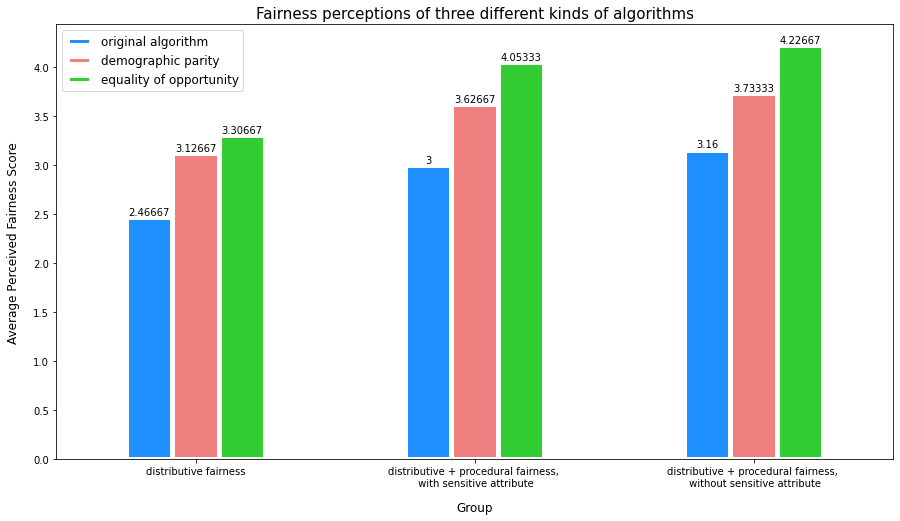

In [17]:
#DESCRIPTIVE STATISTICS 

#Create a list of the mean values and standard deviations for each algorithm
original = [results_dist["Original"].mean(), results_procsens["Original"].mean(), results_procnosens["Original"].mean()]
originalstd = [results_dist["Original"].std(), results_procsens["Original"].std(), results_procnosens["Original"].std()]
originalsem = [results_dist["Original"].sem(), results_procsens["Original"].sem(), results_procnosens["Original"].sem()]
dp = [results_dist["DP_av"].mean(), results_procsens["DP_av"].mean(), results_procnosens["DP_av"].mean()]
dpstd = [results_dist["DP_av"].std(), results_procsens["DP_av"].std(), results_procnosens["DP_av"].std()]
eqo = [results_dist["EQO_av"].mean(), results_procsens["EQO_av"].mean(), results_procnosens["EQO_av"].mean()]
eqostd = [results_dist["EQO_av"].std(), results_procsens["EQO_av"].std(), results_procnosens["EQO_av"].std()]

#Create a list of labels for each group: 
index = ['distributive fairness', 'distributive + procedural fairness, \n with sensitive attribute', 'distributive + procedural fairness, \n without sensitive attribute']

#Create a dataframe with the mean values and labels
df = pd.DataFrame({'original algorithm': original, 'demographic parity': dp, 'equality of opportunity': eqo}, index=index)

#Create a bar plot of the dataframe
ax = df.plot.bar(rot=0, figsize=(15,8), width=0.5, edgecolor="w", linewidth=5, color = ['dodgerblue', 'lightcoral','limegreen'])

#Add labels to the bars 
for container in ax.containers:
    ax.bar_label(container)

#Add a title and labels to the axes:
ax.set_title("Fairness perceptions of three different kinds of algorithms",size= 15)
plt.legend(loc=2, prop={'size': 12})
plt.xlabel("Group", size=12, labelpad=13)
plt.ylabel("Average Perceived Fairness Score", size = 12, labelpad=13)

print("Mean scores per group:")
print("Original algorithm:", original)
print("Demographic parity:", dp)
print("Equality of opportunity:" , eqo)
print()
print("Standard deviations:")
print("Original algorithm:", originalstd)
print("Demographic parity:", dpstd)
print("Equality of opportunity:" , eqostd)
print()
print(originalsem)

In [18]:
# INFERENTIAL STATISTICS 
print("Group 1:", stats.wilcoxon(results_dist['DP_av'], results_dist['EQO_av']))
print("Group 2:",stats.wilcoxon(results_procsens['DP_av'], results_procsens['EQO_av']))
print("Group 3:",stats.wilcoxon(results_procnosens['DP_av'], results_procnosens['EQO_av']))

Group 1: WilcoxonResult(statistic=777.0, pvalue=0.5411496784582348)
Group 2: WilcoxonResult(statistic=601.5, pvalue=0.012949772451431382)
Group 3: WilcoxonResult(statistic=636.5, pvalue=0.016265218195775408)


### RQ2: How do human fairness perceptions of a recruitment prediction algorithm differ when only given information about the distributive fairness of the algorithm, compared to when given information about both the procedural fairness and the distributive fairness of the algorithm?

Mean scores per algorithm:
Distributive: [2.466666666666667, 3.1266666666666665, 3.3066666666666666]
Procedural with sens: [3.0, 3.6266666666666665, 4.053333333333334]
Procedural no sens: [3.16, 3.7333333333333334, 4.226666666666667]

Standard deviations:
Distributive: [1.3490069754526175, 1.2414391532294975, 1.4043689872153444]
Procedural with sens: [1.4142135623730951, 1.3903463824037028, 1.2454602246443565]
Procedural no sens: [1.5160403617247062, 1.3005542823894125, 1.400514705899742]


Text(0, 0.5, 'Average Perceived Fairness Score')

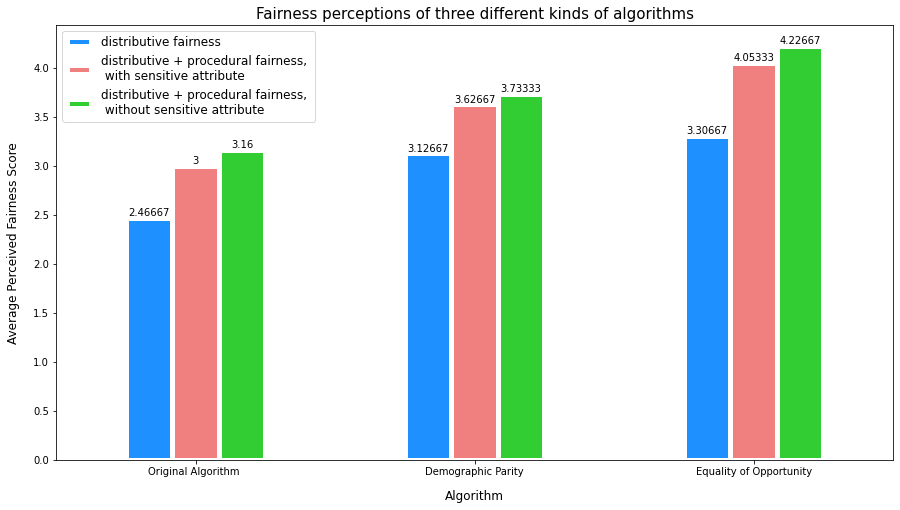

In [19]:
#DESCRIPTIVE STATISTICS

#Create a list of the mean values for each group 
distributive = [results_dist["Original"].mean(), results_dist["DP_av"].mean(),results_dist["EQO_av"].mean()]
diststd = [results_dist["Original"].std(), results_dist["DP_av"].std(), results_dist["EQO_av"].std()]
procedural_sens = [results_procsens["Original"].mean(), results_procsens["DP_av"].mean(), results_procsens["EQO_av"].mean()]
procstd = [results_procsens["Original"].std(), results_procsens["DP_av"].std(), results_procsens["EQO_av"].std()]
procedural_nosens = [results_procnosens["Original"].mean(), results_procnosens["DP_av"].mean(), results_procnosens["EQO_av"].mean()]
procnosensstd = [results_procnosens["Original"].std(), results_procnosens["DP_av"].std(), results_procnosens["EQO_av"].std()]

print("Mean scores per algorithm:")
print("Distributive:", distributive)
print("Procedural with sens:", procedural_sens)
print("Procedural no sens:" , procedural_nosens)
print()
print("Standard deviations:")
print("Distributive:", diststd)
print("Procedural with sens:", procstd)
print("Procedural no sens:" , procnosensstd)


#Create a list of labels for each algorithm: 
index = ['Original Algorithm ', 'Demographic Parity', 'Equality of Opportunity']

#Create a dataframe with the mean values and labels
df = pd.DataFrame({'distributive fairness': distributive, 'distributive + procedural fairness, \n with sensitive attribute': procedural_sens, 'distributive + procedural fairness, \n without sensitive attribute': procedural_nosens}, index=index)

#Create a bar plot of the dataframe
ax = df.plot.bar(rot=0, figsize=(15,8), width=0.5, edgecolor="w", linewidth=5, color = ['dodgerblue', 'lightcoral','limegreen'])

#Add labels to the bars 
for container in ax.containers:
    ax.bar_label(container)

#Add a title and labels to the axes:
ax.set_title("Fairness perceptions of three different kinds of algorithms",size= 15)
plt.legend(loc=2, prop={'size': 12})
plt.xlabel("Algorithm", size=12, labelpad=13)
plt.ylabel("Average Perceived Fairness Score", size = 12, labelpad=13)

In [21]:
#Inferential statistics RQ2
#Kruskal wallis test (non-parametric variant of anova for multiple groups)
print(stats.kruskal(results_dist['Original'], results_procsens['Original'], results_procnosens['Original']))
print(stats.kruskal(results_dist['DP_av'], results_procsens['DP_av'], results_procnosens['DP_av']))
print(stats.kruskal(results_dist['EQO_av'], results_procsens['EQO_av'], results_procnosens['EQO_av']))

#Post hoc analysis to see which groups differ 
x = [results_dist['Original'], results_procsens['Original'], results_procnosens['Original']]
y = [results_dist['DP_av'], results_procsens['DP_av'], results_procnosens['DP_av']]
z = [results_dist['EQO_av'], results_procsens['EQO_av'], results_procnosens['EQO_av']]

print(sp.posthoc_dunn(x))
print(sp.posthoc_dunn(y))
print(sp.posthoc_dunn(z))

KruskalResult(statistic=10.690727800602856, pvalue=0.0047702150067783404)
KruskalResult(statistic=8.452118177880275, pvalue=0.014609853378857635)
KruskalResult(statistic=18.126646181162, pvalue=0.00011583739811754235)
          1         2         3
1  1.000000  0.008512  0.002729
2  0.008512  1.000000  0.714636
3  0.002729  0.714636  1.000000
          1         2         3
1  1.000000  0.043980  0.004763
2  0.043980  1.000000  0.418878
3  0.004763  0.418878  1.000000
          1         2         3
1  1.000000  0.001075  0.000064
2  0.001075  1.000000  0.467766
3  0.000064  0.467766  1.000000


### RQ3A : To what extent is  the disparate impact score of a recruitment prediction algorithm related to human fairness perceptions of it?  
### RQ3B: To what extent is the difference in false negative rates between groups of a recruitment prediction algorithm related to  human fairness perceptions of it?  

In [22]:
#calculate absolute difference in selection rates between groups of each of the models, by substracting the selection rates 

#Original graph (1 = question set A, 2 = question set B)
orig_sr_1 = 0.47-0.12
orig_sr_2 = 0.47-0.12

#Equality of opportunity-mitigated:
eqom_sr_1 = 0.47-0.16
eqom_sr_2 = 0.47-0.16

#Equality of opportunity-perfect:
eqop_sr_1 = 0.47-0.16
eqop_sr_2 = 0.47-0.26

#Demographic parity-mitigated 
dpm_sr_1 = 0.25-0.2
dpm_sr_2 = 0.38-0.3

#Demographic parity-perfect
dpp_sr_1 = 0.2-0.2
dpp_sr_2 = 0.3-0.3

#Calculate false negative differences between groups of each of the models, by substracting the false negative rates

#original graph (1 = question set A, 2 = question set B)
orig_fnr_1 = 0.33-0.16
orig_fnr_2 = 0.33-0.16

#equality of opportunity-mitigated:
eqom_fnr_1 = 0.16-0.13
eqom_fnr_2 = 0.16-0.13

#equality of opportunity-perfect:
eqop_fnr_1 = 0.13-0.13
eqop_fnr_2 = 0.13-0.13

#demographic parity-mitigated 
dpm_fnr_1 = 0.51-0.13
dpm_fnr_2 = 0.51-0.13

#demographic parity-perfect
dpp_fnr_1 = 0.51-0.13
dpp_fnr_2 = 0.51-0.13

#Make a list of all SR and FNR scores 
sr_scores = [orig_sr_1, orig_sr_2, eqom_sr_1, eqom_sr_2, eqop_sr_1, 
             eqop_sr_2, dpm_sr_2, dpm_sr_1, dpp_sr_1, dpp_sr_2]

fnr_scores = [orig_fnr_1, orig_fnr_2, eqom_fnr_1, eqom_fnr_2, eqop_fnr_1, 
              eqop_fnr_2, dpm_fnr_2, dpm_fnr_1, dpp_fnr_1, dpp_fnr_2]


In [23]:
#Create a list of all averaged values for each group 

#Group 1: distributive fairness 
perceived_scores_dist = [results_A_dist['Original'].mean(), results_B_dist['Original'].mean(),
                         results_A_dist['EQO-M'].mean(), results_B_dist['EQO-M'].mean(), 
                         results_A_dist['EQO-P'].mean(), results_B_dist['EQO-P'].mean(),
                         results_B_dist['DP-M'].mean(), results_A_dist['DP-M'].mean(), 
                         results_A_dist['DP-P'].mean(),results_B_dist['DP-P'].mean()]

#create dictionary of false negative rate differences and perceived fairness scores 
f_dist = {'false negative rate difference_1': fnr_scores, 'perceived fairness score_1': perceived_scores_dist}

#create dictionary of selection rate differences and perceived fairness scores 
s_dist = {'selection rate difference_1': sr_scores, 'perceived fairness score_1': perceived_scores_dist}

#Create a list of labels for each algorithm: 
index = ['original model version 1', 'original model version 2', 'equality of opportunity-mitigated version 1', 'equality of opportunity-mitigated version 2', 
         'equality of opportunity version 1', 'equality of opportunity version 2',
         'demographic parity-mitigated version 1', 'demographic parity-mitigated version 2', 
         'demographic parity version 1', 'demographic parity version 2']

#Make a SR (selection rate) dataframe and a FNR (false negative rate) dataframe for group 1
fnr_df_dist = pd.DataFrame(data=f_dist, index=index)
sr_df_dist = pd.DataFrame(data=s_dist, index=index)

In [24]:
#Group 2: distributive + procedural fairness with sensitive attribute  
perceived_scores_procsens = [results_A_procsens['Original'].mean(), results_B_procsens['Original'].mean(),
                         results_A_procsens['EQO-M'].mean(), results_B_procsens['EQO-M'].mean(), 
                         results_A_procsens['EQO-P'].mean(), results_B_procsens['EQO-P'].mean(),
                         results_B_procsens['DP-M'].mean(), results_A_procsens['DP-M'].mean(), 
                         results_A_procsens['DP-P'].mean(),results_B_procsens['DP-P'].mean()]

#create dictionary of false negative rate differences and perceived fairness scores 
f_procsens = {'false negative rate difference_2': fnr_scores, 'perceived fairness score_2': perceived_scores_procsens}

#create dictionary of selection rate differences and perceived fairness scores 
s_procsens = {'selection rate difference_2': sr_scores, 'perceived fairness score_2': perceived_scores_procsens}

#Make a SR dataframe and a FNR dataframe for group 2
fnr_df_procsens = pd.DataFrame(data=f_procsens, index=index)
sr_df_procsens = pd.DataFrame(data=s_procsens, index=index)

In [25]:
#Group 3: distributive + procedural fairness without sensitive attribute  
perceived_scores_procnosens = [results_A_procnosens['Original'].mean(), results_B_procnosens['Original'].mean(),
                         results_A_procnosens['EQO-M'].mean(), results_B_procnosens['EQO-M'].mean(), 
                         results_A_procnosens['EQO-P'].mean(), results_B_procnosens['EQO-P'].mean(),
                         results_B_procnosens['DP-M'].mean(), results_A_procnosens['DP-M'].mean(), 
                         results_A_procnosens['DP-P'].mean(),results_B_procnosens['DP-P'].mean()]

#create dictionary of false negative rate differences and perceived fairness scores 
f_procnosens = {'false negative rate difference_3': fnr_scores, 'perceived fairness score_3': perceived_scores_procnosens}

#create dictionary of selection rate differences and perceived fairness scores 
s_procnosens = {'selection rate difference_3': sr_scores, 'perceived fairness score_3': perceived_scores_procnosens}

#Make a SR dataframe and a FNR dataframe for group 3
fnr_df_procnosens = pd.DataFrame(data=f_procnosens, index=index)
sr_df_procnosens = pd.DataFrame(data=s_procnosens, index=index)

In [26]:
#Concatenate each of these three dataframes into 2 total dataframes containing all scores 
df_fnr_all = pd.concat([fnr_df_dist, fnr_df_procsens, fnr_df_procnosens], axis=1) 
df_sr_all = pd.concat([sr_df_dist, sr_df_procsens, sr_df_procnosens], axis=1) 


#Create new columns with mean selection rate differences / false negative rate differences and perceived fairness scores of each of the three groups
df_fnr_all['mean_fnr'] = df_fnr_all[["false negative rate difference_1","false negative rate difference_2", "false negative rate difference_3"]].mean(axis=1)
df_fnr_all['mean_ps'] = df_fnr_all[["perceived fairness score_1","perceived fairness score_2", "perceived fairness score_3"]].mean(axis=1)

df_sr_all['mean_sr'] = df_sr_all[["selection rate difference_1","selection rate difference_2", "selection rate difference_3"]].mean(axis=1)
df_sr_all['mean_ps'] = df_sr_all[["perceived fairness score_1","perceived fairness score_2", "perceived fairness score_3"]].mean(axis=1)


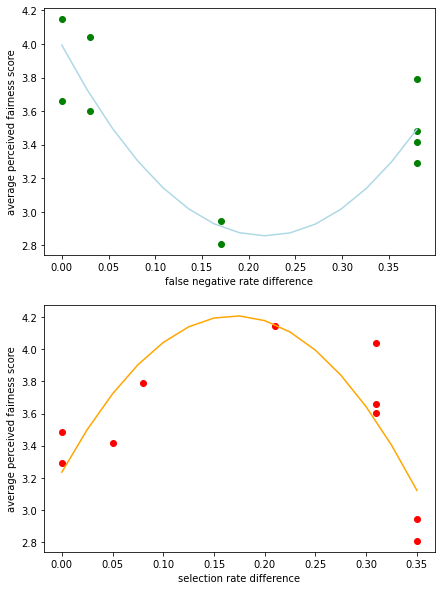

Correlation FNR-PS:  SpearmanrResult(correlation=-0.47989897926858555, pvalue=0.1604123156298613)
Correlation SR-PS:  SpearmanrResult(correlation=-0.17286915020121507, pvalue=0.6329481288184656)


In [27]:
#Plot relationship between FNR/SR differences and perceived fairness scores  

# Plot 1: FNR
x1 = df_fnr_all['mean_fnr']
y1 = df_fnr_all['mean_ps']
z1 = np.polyfit(x1, y1, 2)
f1 = np.poly1d(z1)
x1_new = np.linspace(min(x1), max(x1), 15)
y1_new = f1(x1_new)

# Plot 2: SR 
x2 = df_sr_all['mean_sr']
y2 = df_sr_all['mean_ps']
z2 = np.polyfit(x2, y2, 2)
f2 = np.poly1d(z2)
x2_new = np.linspace(min(x2), max(x2), 15)
y2_new = f2(x2_new)


# Create 1 figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10))

# Subplot 1
ax1.scatter(x1, y1, c='green')
ax1.plot(x1_new, y1_new, color='lightblue')
ax1.set_xlabel('false negative rate difference')
ax1.set_ylabel('average perceived fairness score')

# Subplot 2
ax2.scatter(x2, y2, c='red')
ax2.plot(x2_new, y2_new, color='orange')
ax2.set_xlabel('selection rate difference')
ax2.set_ylabel('average perceived fairness score')

fig.subplots_adjust(wspace=0.4)
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

#Correlations
print("Correlation FNR-PS: ", spearmanr(x1, y1))
print("Correlation SR-PS: ", spearmanr(x2, y2))     

### Demographical Analyses 

In [28]:
#Gender

# First, we concatenate the results of group 1, 2 and 3 
results_total = pd.concat([results_dist, results_procsens, results_procnosens],ignore_index=True)  

# Create a subset of the data of male participants
results_total_male = results_total[results_total['Gender']=='Male']

# Create a subset of the data of female participants
results_total_female = results_total[results_total['Gender']=='Female']

results_dist_female = results_dist[results_dist['Gender']=='Female']
results_dist_male = results_dist[results_dist['Gender']=='Male']

results_procsens_female = results_procsens[results_procsens['Gender']=='Female']
results_procsens_male = results_procsens[results_procsens['Gender']=='Male']

results_procnosens_female = results_dist[results_dist['Gender']=='Female']
results_procnosens_male = results_dist[results_dist['Gender']=='Male']

print("Statistics:")
print("Mean men original:", results_total_male['Original'].mean())
print("Mean women original:", results_total_female['Original'].mean())
print("men-women original", stats.mannwhitneyu(results_total_male['Original'], results_total_female['Original']))
print()
print("Mean men DP:", results_total_male['DP_av'].mean())
print("Mean women DP:", results_total_female['DP_av'].mean())
print("men-women DP", stats.mannwhitneyu(results_total_male['DP_av'], results_total_female['DP_av']))
print()
print("Mean men EQO:", results_total_male['EQO_av'].mean())
print("Mean women EQO:", results_total_female['EQO_av'].mean())
print("men-women EQO", stats.mannwhitneyu(results_total_male['EQO_av'], results_total_female['EQO_av']))
print()

Statistics:
Mean men original: 2.8214285714285716
Mean women original: 2.945945945945946
men-women original MannwhitneyuResult(statistic=5860.5, pvalue=0.2242881214975564)

Mean men DP: 3.4151785714285716
Mean women DP: 3.5585585585585586
men-women DP MannwhitneyuResult(statistic=5747.0, pvalue=0.16353089702137058)

Mean men EQO: 3.861607142857143
Mean women EQO: 3.869369369369369
men-women EQO MannwhitneyuResult(statistic=6109.0, pvalue=0.4119455300298916)



In [29]:
#AI Experience

no_experience = results_total[results_total['AI-exp'].isin(['No', ' no', 'no ', ' No.','no', 'No.', 'Not much', 'Not really',
                                                            'not much', 'None', 'none', 'NO', 'no.', 'Ni'])]

yes_experience = results_total[~results_total.isin(no_experience)].dropna() 

print("Mean experience original:", yes_experience['Original'].mean())
print("Mean no experience original:", no_experience['Original'].mean())

print("Stats original:", stats.mannwhitneyu(yes_experience['Original'], no_experience['Original']))
print()
print("Mean experience dp:", yes_experience['DP_av'].mean())
print("Mean no experience dp:", no_experience['DP_av'].mean())

print("Stats DP:", stats.mannwhitneyu(yes_experience['DP_av'], no_experience['DP_av']))
print()

print("Mean experience dp:", yes_experience['EQO_av'].mean())
print("Mean no experience dp:", no_experience['EQO_av'].mean())

print("Stats EQO:", stats.mannwhitneyu(yes_experience['EQO_av'], no_experience['EQO_av']))


Mean experience original: 2.75
Mean no experience original: 2.897590361445783
Stats original: MannwhitneyuResult(statistic=4337.0, pvalue=0.22117145720588305)

Mean experience dp: 3.8392857142857144
Mean no experience dp: 3.38855421686747
Stats DP: MannwhitneyuResult(statistic=3737.5, pvalue=0.01371128164854577)

Mean experience dp: 3.9464285714285716
Mean no experience dp: 3.8343373493975905
Stats EQO: MannwhitneyuResult(statistic=4435.5, pvalue=0.30378475115432824)


In [30]:
#Age

young = results_total[results_total['Age']<=30]
adult = results_total[(results_total['Age']>30) & (results_total['Age']<=45)]
older = results_total[(results_total['Age']>45) & (results_total['Age']<=60)]
old = results_total[results_total['Age']>60]

print("Mean young or:", young['Original'].mean())
print("Mean adult or:", adult['Original'].mean())
print("Mean older or:", older['Original'].mean())
print("Mean older or:", old['Original'].mean())

print(stats.kruskal(young['Original'], adult['Original'], older['Original']), old['Original'])
print()
print("Mean young dp:", young['DP_av'].mean())
print("Mean adult dp:", adult['DP_av'].mean())
print("Mean older dp:", older['DP_av'].mean())
print("Mean older dp:", old['DP_av'].mean())
print(stats.kruskal(young['DP_av'], adult['DP_av'], older['DP_av']), old['DP_av'])
print()

print("Mean young eqo:", young['EQO_av'].mean())
print("Mean adult eqo:", adult['EQO_av'].mean())
print("Mean older eqo:", older['EQO_av'].mean())
print("Mean older eqo:", old['EQO_av'].mean())

print(stats.kruskal(young['EQO_av'], adult['EQO_av'], older['EQO_av']), old['EQO_av'])



Mean young or: 2.7866666666666666
Mean adult or: 3.05
Mean older or: 2.72
Mean older or: 2.9
KruskalResult(statistic=1.913902357155424, pvalue=0.3840620393726397) 1      2.0
4      5.0
6      1.0
42     3.0
65     5.0
76     3.0
82     5.0
83     4.0
85     1.0
90     2.0
91     2.0
122    3.0
129    1.0
131    2.0
144    2.0
180    4.0
192    4.0
198    3.0
200    3.0
206    3.0
Name: Original, dtype: float64

Mean young dp: 3.62
Mean adult dp: 3.575
Mean older dp: 3.36
Mean older dp: 3.05
KruskalResult(statistic=1.710948559374158, pvalue=0.42508153572778695) 1      4.5
4      2.5
6      1.0
42     3.5
65     3.0
76     3.0
82     3.0
83     5.0
85     1.0
90     2.0
91     3.5
122    4.0
129    1.0
131    4.0
144    3.5
180    2.0
192    3.0
198    4.0
200    3.0
206    4.5
Name: DP_av, dtype: float64

Mean young eqo: 3.986666666666667
Mean adult eqo: 3.775
Mean older eqo: 3.83
Mean older eqo: 3.825
KruskalResult(statistic=0.7317958370192599, pvalue=0.6935735986227702) 1      2.0
4  

In [31]:
#Education 

highschool = results_total[results_total['Education']=='High school diploma']

higher_than_highschool = results_total[~results_total.isin(highschool)].dropna()

print(highschool['Original'].mean())
print(higher_than_highschool['Original'].mean())
print("Stats Orig:", stats.mannwhitneyu(highschool['Original'], higher_than_highschool['Original']))

print()
print(highschool['DP_av'].mean())
print(higher_than_highschool['DP_av'].mean())
print("Stats DP:", stats.mannwhitneyu(highschool['DP_av'], higher_than_highschool['DP_av']))
print()
print(highschool['EQO_av'].mean())
print(higher_than_highschool['EQO_av'].mean())
print("Stats EQO:", stats.mannwhitneyu(highschool['EQO_av'], higher_than_highschool['EQO_av']))



2.875
2.871287128712871
Stats Orig: MannwhitneyuResult(statistic=6040.5, pvalue=0.4835481813128641)

3.35
3.6831683168316833
Stats DP: MannwhitneyuResult(statistic=5252.5, pvalue=0.042985327876631355)

3.9291666666666667
3.762376237623762
Stats EQO: MannwhitneyuResult(statistic=5603.0, pvalue=0.16584738658239434)
